# <center>Tecnologias e Aplicações - TP3<center>

## <center>Transfer Learning<center>

### <center>Equipa<center>
    
<center> - A75569 - João Leal<center>
        
<center> - A74301 - Pedro Almeida<center>
    
<center> - A74357 - António Lopes<center>

# Introdução

&emsp;Até agora, os algoritmos convencionais de Machine Learning foram concebidos para funcionar isoladamente, sendo treinados para resolver tarefas específicas. Os modelos precisam de ser reconstruídos do zero, aquando da alteração da distribuição de recursos no espaço atual.

&emsp;Assim, Transfer Learning é a ideia de superar o paradigma de aprendizagem isolada e utilizar o conhecimento adquirido numa outra tarefa para resolver outras tarefas semelhantes.

&emsp; Serve portanto este trabalho prático para aprofundar as ideias de Transfer Learning e nos familiarizamo-nos com uso de outras redes já existentes para resolver uma tarefa, a classificação de Cães e Gatos.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics

import numpy as np

import os
import pathlib
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
## Input shape options
HEIGHT = 100
WIDTH = 100
NUM_CHANNELS = 3

## Number of classes [Dog,Cat]
NCLASSES = 2
## Number of images per batch
BATCH_SIZE = 32

## Second Dataset size
TRAIN_2_LENGTH = 2500
## Third Dataset size
TRAIN_3_LENGTH = 250

### Contrução da rede

&emsp;A rede utilizada para este trabalho foi a *ResNet50V2*, que conta com 50 layers onde antes de cada layer convolucional é aplicada uma *Batch Normalization*. Consequentemente, usamos os pesos da 'imagenet' e cortamos a cabeça da rede, atribuindo à flag *include_top* o valor **False**.

&emsp;Em seguida congelamos as layers convolucionais de forma a treinar apenas o nosso classificador e alterar os pesos deste, alterando a flag *trainable* para **False**.

&emsp;O classificador, por sua vez, é adicionado tendo em conta o output do modelo usado como base e conta com 1 *fully connected layer* e 2 layers densas, sendo aplicado um dropout de 0.4 antes de cada uma.

In [3]:
weighted_model = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, weights='imagenet', input_shape=(HEIGHT, WIDTH, NUM_CHANNELS))
#weighted_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False,weights='imagenet', input_shape=(HEIGHT, WIDTH, NUM_CHANNELS))

weighted_model.trainable = False

w = weighted_model.output
w = layers.GlobalAveragePooling2D()(w)
w = layers.Dropout(0.4)(w)
w = layers.Dense(4096, activation='relu')(w)
w = layers.Dropout(0.4)(w)
w = layers.Dense(2, activation='softmax')(w)

model_1 = models.Model(inputs=weighted_model.input, outputs=w)
print(model_1.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 52, 52, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________________

### Funções Auxiliares

In [4]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory    
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [WIDTH, HEIGHT])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

---
---

## 1 -  Primeiro Teste


&emsp;Num primeiro teste, usamos a totalidade do dataset disponivel no Kagle de 'Dogs vs Cats' que conta com um total de 23000 imagens (12500 cães e 12500 gatos).

&emsp;Uma vez que são bastantes imagens, o tamanho das mesmas teve de ser reduzido para 100 x 100, de forma a evitar problemas de memória. Este tamanho foi mantido para o segundo e terceiro dataset de treino.

### Load do Dataset

In [5]:
data_dir = pathlib.Path('Train_images/')
  
classNames = np.array(os.listdir(data_dir))

AUTOTUNE = 8

listset_dogs = tf.data.Dataset.list_files("Train_images/dogs/*.jpg")
dataset_dogs = listset_dogs.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

listset_cats = tf.data.Dataset.list_files("Train_images/cats/*.jpg")
dataset_cats = listset_cats.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

dataset = dataset_dogs.concatenate(dataset_cats)
dataset_length = [i for i,_ in enumerate(dataset)][-1] + 1

### Criação do Dataset de Teste

In [6]:
testset = tf.data.Dataset.list_files("Test_images/*/*.jpg")
testset = testset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
testset = testset.batch(batch_size=BATCH_SIZE)

### Criação do Dataset de Treino e Validação

In [7]:
train_size = int(0.8 * dataset_length)
val_size = int(0.2 * dataset_length)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(val_size)

dataset = dataset.prefetch(buffer_size=AUTOTUNE)
#dataset = dataset.batch(batch_size=BATCH_SIZE)
dataset = dataset.repeat()

train_dataset = dataset.take(train_size)
train_dataset = train_dataset.shuffle(buffer_size = train_size)
train_dataset = train_dataset.repeat();
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE)

val_dataset = dataset.skip(train_size)
val_dataset = val_dataset.repeat();
val_dataset = val_dataset.batch(batch_size=BATCH_SIZE)

### Treino do Modelo

In [8]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[ metrics.categorical_accuracy])
history = model_1.fit(train_dataset, epochs=10, steps_per_epoch=train_size/BATCH_SIZE, validation_data = val_dataset, validation_steps= val_size/BATCH_SIZE)

Train for 575.0 steps, validate for 143.75 steps
Epoch 1/10
575/575 [==============================] - 193s 336ms/step - loss: 0.4909 - categorical_accuracy: 0.7760 - val_loss: 0.4534 - val_categorical_accuracy: 0.8678
Epoch 2/10
575/575 [==============================] - 170s 296ms/step - loss: 0.4146 - categorical_accuracy: 0.8029 - val_loss: 0.3689 - val_categorical_accuracy: 0.8852
Epoch 3/10
575/575 [==============================] - 171s 297ms/step - loss: 0.3956 - categorical_accuracy: 0.8148 - val_loss: 0.5489 - val_categorical_accuracy: 0.8446
Epoch 4/10
575/575 [==============================] - 171s 297ms/step - loss: 0.3929 - categorical_accuracy: 0.8132 - val_loss: 0.8047 - val_categorical_accuracy: 0.8010
Epoch 5/10
575/575 [==============================] - 171s 298ms/step - loss: 0.3830 - categorical_accuracy: 0.8233 - val_loss: 0.7711 - val_categorical_accuracy: 0.7917
Epoch 6/10
575/575 [==============================] - 172s 299ms/step - loss: 0.3794 - categorical_ac

### Plot do treino resultante

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


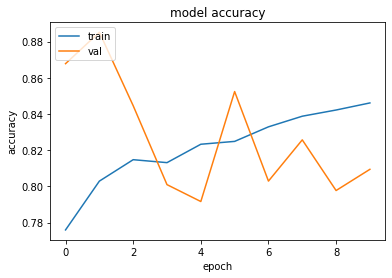

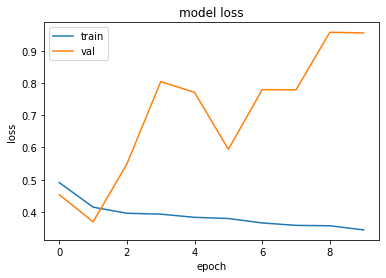

In [9]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Avaliação do Modelo

In [10]:
model_1.evaluate(testset)

63/63 [==============================] - 12s 190ms/step - loss: 0.5354 - categorical_accuracy: 0.8785


[0.5354108024270289, 0.8785]

---
---

## 2 - Segundo Teste

&emsp;Neste segundo teste, diminuímos o tamanho do dataset para 2500 imagens (1250 cães e 1250 gatos), mantendo o dataset de teste.

### Load do Dataset

In [11]:
dataset_2 = dataset_dogs.take(1250).concatenate(dataset_cats.take(1250))

### Criação do Dataset de Treino e Validação

In [12]:
train_size = int(0.8 * TRAIN_2_LENGTH)
val_size = int(0.2 * TRAIN_2_LENGTH)
train_dataset = dataset_2.take(train_size)
val_dataset = dataset_2.skip(val_size)

dataset_2 = dataset_2.prefetch(buffer_size=AUTOTUNE)
dataset_2 = dataset_2.repeat()

train_dataset = dataset_2.take(train_size)
train_dataset = train_dataset.shuffle(buffer_size = train_size)
train_dataset = train_dataset.repeat();
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE)

val_dataset = dataset_2.skip(train_size)
val_dataset = val_dataset.repeat();
val_dataset = val_dataset.batch(batch_size=BATCH_SIZE)

### Treino do Modelo

In [13]:
history = model_1.fit(train_dataset, epochs=10, steps_per_epoch=train_size/BATCH_SIZE, validation_data = val_dataset, validation_steps= val_size/BATCH_SIZE)

Train for 62.5 steps, validate for 15.625 steps
Epoch 1/10
63/62 [==============================] - 19s 309ms/step - loss: 0.3398 - categorical_accuracy: 0.8562 - val_loss: 0.2775 - val_categorical_accuracy: 0.9258
Epoch 2/10
63/62 [==============================] - 18s 280ms/step - loss: 0.3590 - categorical_accuracy: 0.8452 - val_loss: 0.4367 - val_categorical_accuracy: 0.9023
Epoch 3/10
63/62 [==============================] - 18s 280ms/step - loss: 0.3351 - categorical_accuracy: 0.8562 - val_loss: 0.3991 - val_categorical_accuracy: 0.9043
Epoch 4/10
63/62 [==============================] - 18s 279ms/step - loss: 0.3360 - categorical_accuracy: 0.8532 - val_loss: 0.3916 - val_categorical_accuracy: 0.9160
Epoch 5/10
63/62 [==============================] - 18s 285ms/step - loss: 0.3487 - categorical_accuracy: 0.8472 - val_loss: 0.5013 - val_categorical_accuracy: 0.9062
Epoch 6/10
63/62 [==============================] - 18s 290ms/step - loss: 0.3370 - categorical_accuracy: 0.8447 - va

### Plot do treino resultante

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


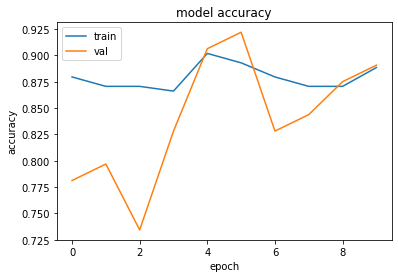

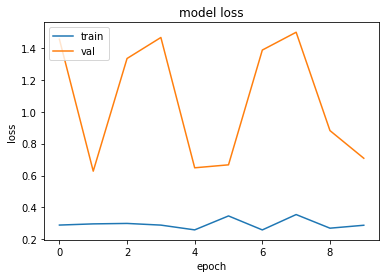

In [19]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Avaliação do Modelo

In [14]:
model_1.evaluate(testset)

63/63 [==============================] - 11s 179ms/step - loss: 0.4405 - categorical_accuracy: 0.8980


[0.44053004331155016, 0.898]

---
---

## 3 - Terceiro Teste

&emsp;Num último teste, diminuímos novamente o tamanho do dataset para 250 imagens (125 cães e 125 gatos), mantendo o dataset de teste.

### Load do Dataset

In [15]:
dataset_3 = dataset_dogs.take(125).concatenate(dataset_cats.take(125))

### Criação do Dataset de Treino e Validação

In [16]:
train_size = int(0.8 * TRAIN_3_LENGTH)
val_size = int(0.2 * TRAIN_3_LENGTH)
train_dataset = dataset_3.take(train_size)
val_dataset = dataset_3.skip(val_size)

dataset_3 = dataset_3.prefetch(buffer_size=AUTOTUNE)
#dataset = dataset.batch(batch_size=BATCH_SIZE)
dataset_3 = dataset_3.repeat()

train_dataset = dataset_3.take(train_size)
train_dataset = train_dataset.shuffle(buffer_size = train_size)
train_dataset = train_dataset.repeat();
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE)

val_dataset = dataset_3.skip(train_size)
val_dataset = val_dataset.repeat();
val_dataset = val_dataset.batch(batch_size=BATCH_SIZE)

### Treino do Modelo

In [17]:
history = model_1.fit(train_dataset, epochs=10, steps_per_epoch=train_size/BATCH_SIZE, validation_data = val_dataset, validation_steps= val_size/BATCH_SIZE)

Train for 6.25 steps, validate for 1.5625 steps
Epoch 1/10
7/6 [=================================] - 2s 356ms/step - loss: 0.2899 - categorical_accuracy: 0.8795 - val_loss: 1.4533 - val_categorical_accuracy: 0.7812
Epoch 2/10
7/6 [=================================] - 2s 307ms/step - loss: 0.2974 - categorical_accuracy: 0.8705 - val_loss: 0.6275 - val_categorical_accuracy: 0.7969
Epoch 3/10
7/6 [=================================] - 2s 306ms/step - loss: 0.3002 - categorical_accuracy: 0.8705 - val_loss: 1.3330 - val_categorical_accuracy: 0.7344
Epoch 4/10
7/6 [=================================] - 2s 303ms/step - loss: 0.2897 - categorical_accuracy: 0.8661 - val_loss: 1.4645 - val_categorical_accuracy: 0.8281
Epoch 5/10
7/6 [=================================] - 2s 305ms/step - loss: 0.2598 - categorical_accuracy: 0.9018 - val_loss: 0.6485 - val_categorical_accuracy: 0.9062
Epoch 6/10
7/6 [=================================] - 2s 313ms/step - loss: 0.3471 - categorical_accuracy: 0.8929 - va

### Plot do treino resultante

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


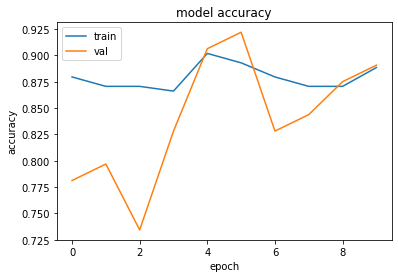

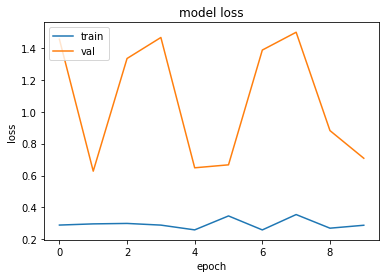

In [20]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Avaliação do Modelo

In [18]:
model_1.evaluate(testset)

63/63 [==============================] - 11s 178ms/step - loss: 0.5038 - categorical_accuracy: 0.8950


[0.5038141021283254, 0.895]

# Análise de resultados

&emsp;Embora a precisão do modelo ronde apenas os 90%, é possível observar na íntegra a utilidade da técnica de Transfer Learning. 
&emps; Após ser testado em 3 datasets de tamanhos diferentes, a rede conseguiu apresentar iguais ou melhores resultados no dataset mais pequeno, justificando a capacidade que a técnica de Transfer Learning possui em ser capaz de resolver problemas (semelhantes) mesmo com escassez de dados.

---
---

# Conclusão

&emsp;Com o desenvolvimento deste projeto foi possível observar a utilidade desta técnica de Machine Learning quando usada em datasets pequenos, mostrando-se capaz de obter bons resultados mesmo com poucas imagens. Além disso, foi também possível observar a facilidade com que nos é permitido usar o conhecimento adquirido noutras tarefas para resolver problemas novos, mas semelhantes, de maneira rápida e eficaz.

&emsp;Importante também referir que foram sentidas algumas dificuldades ao longo do desenvolvimento do projeto, tendo sido confrontado com alguns problemas de alocação de memória, resolvidos através da redução do tamanho das imagens usadas e do BATCH_SIZE usado, sentido algumas consequências na precisão do modelo.

&emsp;Contudo, o projeto proposto foi certamente útil para explorar esta técnica de Machine Learning que potencia a partilha de conhecimento dos vários modelos existentes ao mesmo tempo que se mostra promissora e útil na resolução de vários problemas, através desta mesma partilha.